<a href="https://colab.research.google.com/github/rblanco2023/NLP/blob/main/Desaf%C3%ADo_2_bot_dnn_spacy_esp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot basado en reglas con DNN + Spacy

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [ ]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
!pip install -U spacy>=3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

     |████████████████████████████████| 342 kB 9.6 MB/s 


In [ ]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

2022-07-05 02:09:13 INFO: Downloading default packages for language: es (Spanish)...


2022-07-05 02:11:04 INFO: Finished downloading models and saved to /root/stanza_resources.
2022-07-05 02:11:04 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2022-07-05 02:11:04 INFO: Use device: cpu
2022-07-05 02:11:04 INFO: Loading: tokenize
2022-07-05 02:11:04 INFO: Loading: mwt
2022-07-05 02:11:04 INFO: Loading: pos
2022-07-05 02:11:04 INFO: Loading: lemma
2022-07-05 02:11:04 INFO: Loading: depparse
2022-07-05 02:11:05 INFO: Loading: ner
2022-07-05 02:11:06 INFO: Done loading processors!


### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [ ]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    # sacar tildes de las palabras
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    # quitar números
    #text = re.sub(pattern, '', text)
    # quitar caracteres de puntiación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

In [ ]:
text = "personas Ideas! estás cosas y los peces y los muercielagos"

# Antes de preprocesar los datos se pasa a mínusculas todo el texto
preprocess_clean_text(text.lower())

'personas ideas estas cosas y los peces y los muercielagos'

In [ ]:
# Ejemplo de como fuciona
text = "hola personas Ideas! estás cosas y los peces y los muercielagos"

# Antes de preprocesar los datos se pasa a mínusculas todo el texto
tokes = nlp(preprocess_clean_text(text.lower()))
print("tokens:", tokes)
print("Lematización de cada token:")
for token in tokes:
    print([token, token.lemma_])

tokens: hola personas ideas estas cosas y los peces y los muercielagos
Lematización de cada token:
[hola, 'holar']
[personas, 'persona']
[ideas, 'idea']
[estas, 'este']
[cosas, 'cosa']
[y, 'y']
[los, 'el']
[peces, 'pez']
[y, 'y']
[los, 'el']
[muercielagos, 'muercielago']


### 3 - Diccionario de entrada

In [ ]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?"],
              "responses": ["Hola!", "Hola, bienvenido a CineUno", "Bienvenido a CineUno", "Usted está hablando con Cinebot de CineUno"],
             },
             {"tag": "nombre",
              "patterns": ["¿Cúal es tu nombre?", "¿Quién sos?", "Hola, ¿con quien hablo?", "¿Cómo te llamás?"],
              "responses": ["Mi nombre es Cinebot", "Yo soy Cinebot", "usted está hablando con Cinebot", "Cinebot a su servicio"]
             },
            {"tag": "peliculas",
              "patterns": ["quiero saber que peliculas hay en cartelera", "¿que pelicula puedo ver?", "¿Que cartelera hay hoy?", "¿Que puedo ver?"],
              "responses": ["Las peliculas en cartelera son: Volver al futuro, Forest Gump, Rescatando al soldado Ryan y Superman 3", "Hoy puede ver: Volver al futuro, Forest Gump, Rescatando al soldado Ryan, Superman 3", "En cartelera tenemos: Volver al futuro, Forest Gump, Rescatando al soldado Ryan, Superman 3"]
             },
            {"tag": "peli1",
              "patterns": ["Quiero ver Volver al Futuro", "Elijo Volver al Futuro", "Volver al Futuro", "Me gusta Volver al Futuro"],
              "responses": ["Los horarios para Volver al Futuro son: 18, 21:30 y 23hs. ¿Que horario prefiere?"]
             },
            {"tag": "peli2",
              "patterns": ["Quiero ver Forest Gump", "Elijo Forest Gump", "Forest Gump", "Me gusta Forest Gump"],
              "responses": ["Los horarios para Forest Gump son: 17 y 22hs. ¿Que horario prefiere?"]
             },
            {"tag": "peli3",
              "patterns": ["Quiero ver Rescatando al soldado Ryan", "Elijo Rescatando al soldado Ryan", "Rescatando al soldado Ryan", "Me gusta Rescatando al soldado Ryan"],
              "responses": ["Los horarios para ver Rescatando al soldado Ryan son: 18, 22:30 y 23:30hs. ¿Que horario prefiere?"]
             },
            {"tag": "peli4",
              "patterns": ["Quiero ver Superman 3", "Elijo Superman 3", "Superman 3", "Me gusta Superman 3"],
              "responses": ["Los horarios para Superman 3 son: 16, 17:30, 19 y 21hs. ¿Que horario prefiere?"]
             },
            {"tag": "precios",
              "patterns": ["Elijo 16hs", "Elijo 17hs", "Elijo 17:30", "Elijo 18hs", "Elijo 19hs", "Elijo 21hs", "Elijo 21:30hs", "Elijo 22hs", "Elijo 22:30hs", "Elijo 23hs", "Elijo 23:30hs"],
              "responses": ["Perfecto, el precio de la entrada es de $650"]
             },
            {"tag": "pagos",
              "patterns": ["¿Cómo puedo pagar?", "¿Puedo pagar con Tarjeta de crédito?", "¿Aceptan Tarjetas?", "¿aceptan Mercadopagos?"],
              "responses": ["Puede pagar con efectivo, con tarjeta de crédito y débito y con Mercadopagos"]
             },
            {"tag": "pagar",
              "patterns": ["Voy a pagar en efectivo", "voy a pagar con tarjeta de crédito", "voy a pagar con tarjeta", "voy a pagar con Mercadopagos"],
              "responses": ["Si, claro que aceptamos ese medio de pago"]
             },
            {"tag": "agradecimientos",
              "patterns": [ "Muchas gracias", "Gracias"],
              "responses": ["Por nada!, cualquier otra consulta podes escribirme"]
             },
             {"tag": "despedida",
              "patterns": [ "Chau", "Hasta luego!"],
              "responses": ["Que disfrutes la pelicula!", "No te olvides del pochoclo!", "Gracias por elegirnos!"]
             }
]}

### 4 - Preprocesamiento y armado del dataset

In [ ]:
# Datos que necesitaremos, las palabras o vocabilario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para lamacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

/usr/local/lib/python3.7/dist-packages/stanza/models/common/beam.py:86: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  prevK = bestScoresId // numWords
/usr/local/lib/python3.7/dist-packages/spacy/language.py:1008: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  doc = self._ensure_doc(text)
/usr/local/lib/python3.7/dist-packages/spacy/language.py:1008: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['quiero', 'ver', 'volver', 'a', 'el', 'fut

In [ ]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['16h', '1730', '17h', '18h', '19hs', '2130hs', '21hs', '2230hs', '22hs', '2330hs', '23h', '3', 'a', 'aceptar', 'cartelera', 'chau', 'como', 'con', 'credito', 'cual', 'de', 'efectivo', 'el', 'elegir', 'en', 'este', 'forest', 'futuro', 'gracias', 'gump', 'gustar', 'haber', 'hablar', 'hasta', 'holar', 'hoy', 'ir', 'llama', 'luego', 'mercadopago', 'mucho', 'nombre', 'pagar', 'pelicula', 'poder', 'que', 'querer', 'quien', 'rescatar', 'ryan', 'saber', 'ser', 'soldado', 'superman', 'tal', 'tarjeta', 'tu', 'tú', 'ver', 'volver', 'yo']
classes: ['agradecimientos', 'bienvenida', 'despedida', 'nombre', 'pagar', 'pagos', 'peli1', 'peli2', 'peli3', 'peli4', 'peliculas', 'precios']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', '¿Cúal es tu nombre?', '¿Quién sos?', 'Hola, ¿con quien hablo?', '¿Cómo te llamás?', 'quiero saber que peliculas hay en cartelera', '¿que pelicula puedo ver?', '¿Que cartelera hay hoy?', '¿Que puedo ver?', 'Quiero ver Volver al Futuro', 'Elijo Volver al Futuro', 'Volver

In [ ]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 61


In [ ]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 12


In [ ]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0] y: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

/usr/local/lib/python3.7/dist-packages/stanza/models/common/beam.py:86: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  prevK = bestScoresId // numWords
/usr/local/lib/python3.7/dist-packages/spacy/language.py:1008: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  doc = self._ensure_doc(text)
/usr/local/lib/python3.7/dist-packages/spacy/language.py:1008: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['quiero', 'ver', 'volver', 'a', 'el', 'fut

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0] y: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] y: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


/usr/local/lib/python3.7/dist-packages/spacy/language.py:1008: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['elijo', 'volver', 'a', 'el', 'futuro']
Entities: []
  doc = self._ensure_doc(text)
/usr/local/lib/python3.7/dist-packages/spacy/language.py:1008: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['volver', 'a', 'el', 'futuro']
Entities: []
  doc = self._ensure_doc(text)


X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] y: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1] y: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


/usr/local/lib/python3.7/dist-packages/spacy/language.py:1008: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['me', 'gusta', 'volver', 'a', 'el', 'futuro']
Entities: []
  doc = self._ensure_doc(text)


X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] y: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] y: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


/usr/local/lib/python3.7/dist-packages/spacy/language.py:1008: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['quiero', 'ver', 'rescatando', 'a', 'el', 'soldado', 'ryan']
Entities: []
  doc = self._ensure_doc(text)
/usr/local/lib/python3.7/dist-packages/spacy/language.py:1008: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['elijo', 'rescatando', 'a', 'el', 'soldado', 'ryan']
Entities: []
  doc = self._ensure_doc(text)


X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0] y: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


/usr/local/lib/python3.7/dist-packages/spacy/language.py:1008: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['rescatando', 'a', 'el', 'soldado', 'ryan']
Entities: []
  doc = self._ensure_doc(text)
/usr/local/lib/python3.7/dist-packages/spacy/language.py:1008: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['me', 'gusta', 'rescatando', 'a', 'el', 'soldado', 'ryan']
Entities: []
  doc = self._ensure_doc(text)


X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1] y: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0] y: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### 5 - Entrenamiento del modelo

In [ ]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (61,) output: 12


In [ ]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(256, input_shape=input_shape, activation="relu"))  #128
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               15872     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 12)                7

In [ ]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
2/2 [==============================] - 1s 9ms/step - loss: 2.4887 - accuracy: 0.0800
Epoch 2/200
2/2 [==============================] - 0s 8ms/step - loss: 2.5302 - accuracy: 0.0600
Epoch 3/200
2/2 [==============================] - 0s 7ms/step - loss: 2.4550 - accuracy: 0.1200
Epoch 4/200
2/2 [==============================] - 0s 12ms/step - loss: 2.4943 - accuracy: 0.1000
Epoch 5/200
2/2 [==============================] - 0s 7ms/step - loss: 2.4054 - accuracy: 0.2400
Epoch 6/200
2/2 [==============================] - 0s 7ms/step - loss: 2.4316 - accuracy: 0.2000
Epoch 7/200
2/2 [==============================] - 0s 7ms/step - loss: 2.3792 - accuracy: 0.2200
Epoch 8/200
2/2 [==============================] - 0s 9ms/step - loss: 2.4024 - accuracy: 0.1400
Epoch 9/200
2/2 [==============================] - 0s 7ms/step - loss: 2.3543 - accuracy: 0.2000
Epoch 10/200
2/2 [==============================] - 0s 8ms/step - loss: 2.3308 - accuracy: 0.1800
Epoch 11/200
2/2 [==========

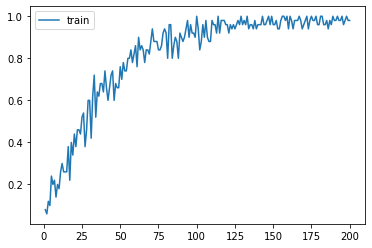

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [ ]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 6 - Testing y validación

In [ ]:
def text_to_tokens(text): 
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0:
        result = model.predict(np.array([bow]))[0]
        thresh = 0.2
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]
    list_of_intents = intents_json["intents"]
    for i in list_of_intents: 
        if i["tag"] == tag:
            result = "BOT: " + random.choice(i["responses"])
            break
    return result

In [ ]:
while True:
    message = input("")
    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print(result)
    else:
        print("Perdón, no comprendo la pregunta.")
    

Hola!
BOT: Bienvenido a CineUno
Que pelicula puedo ver hoy?
BOT: En cartelera tenemos: Volver al futuro, Forest Gump, Rescatando al soldado Ryan, Superman 3
Elijo Forest Gump
BOT: Los horarios para Forest Gump son: 17 y 22hs. ¿Que horario prefiere?
22hs
BOT: Perfecto, el precio de la entrada es de $650
como puedo pagar?
BOT: Puede pagar con efectivo, con tarjeta de crédito y débito y con Mercadopagos
voy a pagar con Mercadopagos
BOT: Si, claro que aceptamos ese medio de pago
perfecto, muchas gracias
BOT: Por nada!, cualquier otra consulta podes escribirme
Chau
BOT: Gracias por elegirnos!


KeyboardInterrupt: ignored

### 7 - Conclusiones
El bot tal cual está definido es capaz de responder a bastantes tipos de preguntas con gran precisión. Algunas técnicas que podrían ensayarse para evaluar como impactan en el sistema son:
- Filtrar los stop words
- Utilizar TF-IDF en vez de bag of words